# Analysis & Visualization of Produced Water Chemistry for Environmental & Agricultural Utilization

## SETUP

In [2]:
# Dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import sklearn

## DATA CLEANING & FILTERING

In [3]:
# Load the data from the CSV files
df1 = pd.read_csv('../data/split_1_USGSPWDBv2.3n.csv', low_memory=False)
df2 = pd.read_csv('../data/split_2_USGSPWDBv2.3n.csv', low_memory=False)
df3 = pd.read_csv('../data/split_3_USGSPWDBv2.3n.csv', low_memory=False)

# Concatenate the dataframes
frames = [df1, df2, df3]
df_merged = pd.concat(frames, ignore_index=True)

# Save the concatenated dataframe to a new CSV file
df_merged.to_csv('../data/df_merged.csv', index=False)

In [4]:
# List of columns to be removed
columns_to_remove = [
    "IDDB", "SOURCE", "REFERENCE", "LATLONGAPX", "USGSREGION", "BASINCODE", 
    "STATECODE", "COUNTYCODE", "FIELD", "FIELDCODE", "WELLCODE", "TOWNRANGE", 
    "REGDIST", "LOC", "QUAD", "DAY", "DATECOMP", "DATEANALYS", "METHOD", 
    "OPERATOR", "PERMIT", "DFORM", "GROUP", "MEMBER", "AGECODE", "ERA", 
    "PERIOD", "EPOCH", "LAB", "REMARKS", "LITHOLOGY", "POROSITY", "TEMP", 
    "PRESSURE", "SG", "SPGRAV", "SPGRAVT", "RESIS", "RESIST", "PH", "PHT", 
    "EHORP", "COND", "CONDT", "TURBIDITY", "HEM", "MBAS","TDS","TDSCALC", "TSS", "CHARGEBAL", 
    "ACIDITY", "DIC", "DOC", "TOC", "CN", "BOD", "COD", "BENZENE", "TOLUENE", 
    "ETHYLBENZ", "XYLENE", "ACETATE", "BUTYRATE", "FORMATE", "LACTATE", 
    "PHENOLS", "PERC", "PROPIONATE", "PYRUVATE", "VALERATE", "ORGACIDS", 
    "Ar", "CH4", "C2H6", "CO2", "H2", "H2S", "He", "N2", "NH3", "O2", "ALPHA", 
    "BETA", "dD", "H3", "d7Li", "d11B", "d13C", "C14", "d18O", "d34S", 
    "d37Cl", "K40", "d81Br", "Sr87Sr86", "I129", "Rn222", "Ra226", "Ra228", 
    "cull_PH", "cull_MgCa", "cull_KCl", "cull_K5Na", "Ag", "Al", "As", "Au", 
    "B", "BO3", "Be", "Bi", "Cd", "Co", "Cr", "Cs", "Cu", "F", "FeS", "FeAl", 
    "FeAl2O3", "Hg", "I", "Mn", "Mo", "N", "NO2", "NO3", "NO3NO2", "NH4", 
    "TKN", "Ni", "OH", "P", "PO4", "Pb", "Rh", "Rb", "S", "SO3", "HS", "Sb", 
    "Sc", "Se", "Sn", "Ti", "Tl", "U", "V", "W", "Zn"
]

# Remove the specified columns
df_limited_column = df_merged.drop(columns=columns_to_remove, errors='ignore')

# Display the updated merged dataframe
df_limited_column.to_csv('../data/df_limited_column.csv', index=False)

# Remove rows where TDSUSGS <= 35000 (sea water to eliminate all coalebed methane produced water and also the failing analyses)
df_filtered = df_limited_column[df_limited_column['TDSUSGS'] > 35000]

# Save the filtered dataframe to a new CSV file
df_filtered.to_csv('../data/df_filtered_TDS.csv', index=False)

In [5]:
# Fill NaN values in 'KNa', 'K', 'Na', 'Ca', 'Cl', 'SO4', 'Mg' with zeros for calculation
for col in ['KNa', 'K', 'Na', 'Ca', 'Cl', 'SO4', 'Mg']:
    df_filtered[col].fillna(0, inplace=True)

# First, we'll fill NaN values in 'KNa' and 'K' with zeros for the calculation.
df_filtered['KNa'].fillna(0, inplace=True)
df_filtered['K'].fillna(0, inplace=True)

# Apply conditions to calculate 'Na'
# If 'Na' is missing and both 'KNa' and 'K' are present, populate 'Na' with 'KNa' - 'K'
# If 'Na' is missing and 'KNa' is present but 'K' is not, populate 'Na' with 'KNa'

na_mask = df_filtered['Na'].isna()
na_present = df_filtered['Na'] > 0
kna_present = df_filtered['KNa'] > 0
k_present = df_filtered['K'] > 0
k_missing = df_filtered['K'] == 0

df_filtered.loc[k_missing & na_present & kna_present, 'K'] = df_filtered['KNa'] - df_filtered['Na']
df_filtered.loc[na_mask & kna_present & k_present, 'Na'] = df_filtered['KNa'] - df_filtered['K']
df_filtered.loc[na_mask & kna_present & ~k_present, 'Na'] = df_filtered['KNa']

# Remove rows where 'Na' is still missing
df_filtered.dropna(subset=['Na'], inplace=True)

# Remove rows where 'Cl' is missing
df_filtered.dropna(subset=['Cl'], inplace=True)

# Save the updated dataframe 
df_filtered.to_csv('../data/df_filtered_Na_Cl.csv', index=False)

/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_46298/3587715086.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col].fillna(0, inplace=True)
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_46298/3587715086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['KNa'].fillna(0, inplace=True)
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_46298/3587715086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [6]:
#To calculate the molar concentrations from concentrations given in ppm (parts per million) or mg/L,
#these values need to be converted into moles per liter (M). The formula to convert ppm or mg/L to M is:

                #Molarity (M)=Concentration (mg/L)/ Molar Mass (g/mol) 

#This calculation assumes that 1 ppm is equivalent to 1 mg/L. The molar mass of each element or compound (Na, Ca, Cl, SO4, and Mg) 
#is a constant value based on its atomic or molecular weight.

#Apply the conditions (molar Na > molar Ca) and (molar Cl > molar SO4) and (molar Ca > molar Mg/2) which represent likely unnatural combinations
# Convert concentrations from ppm (mg/L) to Molarity (M)
molar_masses = {'Na': 22.99, 'Ca': 40.08, 'Cl': 35.45, 'SO4': 96.06, 'Mg': 24.305}
for element, molar_mass in molar_masses.items():
    df_filtered[element + '_M'] = df_filtered[element] / molar_mass

# Apply the conditions (molar Na > molar Ca) and (molar Cl > molar SO4) and (molar Ca > molar Mg/2)
condition = (df_filtered['Na_M'] > df_filtered['Ca_M']) & \
            (df_filtered['Cl_M'] > df_filtered['SO4_M']) & \
            (df_filtered['Ca_M'] > df_filtered['Mg_M'] / 2)

df_filtered = df_filtered[condition]

# Save the updated dataframe
df_filtered.to_csv('../data/df_filtered_corrected_elemental_ratios.csv', index=False)

/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_46298/3949465626.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[element + '_M'] = df_filtered[element] / molar_mass
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_46298/3949465626.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[element + '_M'] = df_filtered[element] / molar_mass
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_46298/3949465626.py:13: SettingWithCopyWarning: 
A value is trying 

In [7]:
# Filter out rows where USGS charge balance is not between -10 and +10
df_filtered = df_filtered[df_filtered['chargebalance'].between(-10, 10)]

# Save the updated dataframe
df_filtered.to_csv('../data/df_filtered_chargebalance.csv', index=False)

In [8]:
# Calculate charge balance
df_filtered['Cations'] = (df_filtered['Na_M'] * 1) + (df_filtered['Ca_M'] * 2) + (df_filtered['Mg_M'] * 2)
df_filtered['Anions'] = (df_filtered['Cl_M'] * 1) + (df_filtered['SO4_M'] * 2)
df_filtered['CalculatedChargeBalance'] = ((df_filtered['Cations'] - df_filtered['Anions']) / (df_filtered['Cations'] + df_filtered['Anions'])) * 100

# Flag discrepancies between calculated charge balance and existing 'chargebalance' column
threshold = 5  # 5% threshold for discrepancy
df_filtered['ChargeBalanceDiscrepancy'] = abs(df_filtered['CalculatedChargeBalance'] - df_filtered['chargebalance']) > threshold

# Save the updated dataframe with discrepancy flags
df_filtered.to_csv('../data/df_filtered_discrepancy_flags.csv', index=False)

In [9]:
# Calculate DEPTHWELL where it's missing
df_filtered_depth=df_filtered.copy()

for index, row in df_filtered_depth.iterrows():
    if pd.isna(row['DEPTHWELL']):
        if pd.notna(row['DEPTHUPPER']) and pd.notna(row['DEPTHLOWER']):
            # Calculate DEPTHWELL as difference between DEPTHUPPER and DEPTHLOWER
            df_filtered_depth.at[index, 'DEPTHWELL'] = row['DEPTHLOWER'] - row['DEPTHUPPER']
        elif pd.notna(row['DEPTHUPPER']):
            # Populate DEPTHWELL with DEPTHUPPER
            df_filtered_depth.at[index, 'DEPTHWELL'] = row['DEPTHUPPER']
        elif pd.notna(row['DEPTHLOWER']):
            # Populate DEPTHWELL with DEPTHLOWER
            df_filtered_depth.at[index, 'DEPTHWELL'] = row['DEPTHLOWER']

# Remove rows where DEPTHWELL, DEPTHUPPER, and DEPTHLOWER are all missing
df_filtered_depth.dropna(subset=['DEPTHWELL'], inplace=True)

# Save the updated dataframe with updated well depth
df_filtered_depth.to_csv('../data/df_filtered_welldepth.csv', index=False)

## ANALYSIS 

## VISUALIZATION

### Piper Plots

In [10]:
# Dependencies
from wqchartpy import triangle_piper
from wqchartpy import contour_piper
from wqchartpy import color_piper
# WILL MOVE THESE TO SETUP SECTION AT THE TOP OF THE NOTEBOOK ONCE WE LAND ON WHICH PLOTS WE'RE USING

In [11]:
'''
    Because wqchartpy and plt.savefig() automatically generate the plot image files within the current directory as part of the module code, the following function is needed to push 
    them to our images folder as they're generated to keep our file structure organized automatically. A function was created since this will be used repeatedly.
'''

def move_image_file_to_images_folder(image_file_name):
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    current_file_path = os.path.join(parent_directory, 'notebooks', image_file_name)
    image_folder_path = os.path.join(parent_directory, 'images')
    new_file_path = os.path.join(image_folder_path, image_file_name)

    # Check if the images folder exists; if not, it gets created
    if not os.path.exists(image_folder_path):
        os.makedirs(image_folder_path)

    # Check if a file with the same name already exists in the destination folder; if so ask user what to do: override with or without deleting the newly generated image
    if os.path.exists(new_file_path):
        user_input = input(f"A file with the name '{image_file_name}' already exists in 'images' folder. Do you want to override it? (y/n): ").lower()
        if user_input != 'y':
            user_input = input(f'Do you want to delete the newly generated image file? (y/n): ').lower()
            if user_input == 'y':
                os.remove(current_file_path)
                print('File deleted.')
                return
            else:
                print(f'File not deleted. It is located in {current_directory}.')
            print(f'File not moved to images folder. It is located in {current_directory}.')
            return

    # Move the file to the destination folder
    new_file_path = os.path.join(image_folder_path, image_file_name)
    os.rename(current_file_path, new_file_path)

    print(f"File '{image_file_name}' moved to 'images' folder.")

In [12]:
# THIS CODE CELL NOT NEEDED LATER - JUST HERE UNTIL WE CAN FEED IN THE REAL CLEANED DATAFRAME DOWN THE LINE
# THIS DATAFRAME IS SIMPLY BASED ON THE "SPLIT_1" CSV FILE MANUALLY FILTERED VIA EXCEL TO HAVE NO BLANKS IN THE WQCHARTPY REQUIRED ELEMENT COLUMNS - NO OTHER LOGIC OR ANALYSIS APPLIED
dirtyscrubdata_path = os.path.join('brittanys_temp_folder_ignoreme','split_1_dirtyscrubdatafortesting.csv')
df_dirtyscrubdata = pd.read_csv(dirtyscrubdata_path,delimiter=',')
df_dirtyscrubdata.head(2)

,IDUSGS,CO3,HCO3,Ca,Cl,K,Mg,Na,SO4,Unnamed: 9,...,Unnamed: 180,Unnamed: 181,Unnamed: 182,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186,Unnamed: 187,Unnamed: 188,Unnamed: 189
0,321,24.0,358.0,3.2,870.0,39.0,2.0,703.0,112.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,323,12.0,52.0,40.0,49.0,13.0,1.0,313.0,642.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
columns_to_keep = ['IDUSGS', 'Ca', 'Mg', 'Na', 'K', 'HCO3', 'CO3', 'Cl', 'SO4']
df_dirtyscrubdata_lesscol = df_dirtyscrubdata.drop(columns=df_dirtyscrubdata.columns.difference(columns_to_keep))
df_dirtyscrubdata_lesscol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IDUSGS  1046 non-null   int64  
 1   CO3     1046 non-null   float64
 2   HCO3    1046 non-null   float64
 3   Ca      1046 non-null   float64
 4   Cl      1046 non-null   float64
 5   K       1046 non-null   float64
 6   Mg      1046 non-null   float64
 7   Na      1046 non-null   float64
 8   SO4     1046 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 73.7 KB


In [14]:
mask = df_filtered['BASIN'] == 'Permian'
df_filtered_permian = df_filtered[mask]
df_filtered_permian.head(2)

,IDUSGS,IDORIG,LATITUDE,LONGITUDE,API,BASIN,STATE,COUNTY,WELLNAME,WELLTYPE,...,cull_chargeb,Na_M,Ca_M,Cl_M,SO4_M,Mg_M,Cations,Anions,CalculatedChargeBalance,ChargeBalanceDiscrepancy
176,177,14-TX-01B,31.90,-101.44,NaN,Permian,Texas,Glasscock,NaN,Conventional Hydrocarbon,...,NaN,965.637234,54.640719,1122.708039,16.448053,16.580950,1108.080572,1155.604146,-2.09939,False
177,178,14-TX-02B,31.91,-101.44,NaN,Permian,Texas,Glasscock,NaN,Tight Oil,...,NaN,1096.128752,61.127745,1306.064880,3.653966,13.536309,1245.456859,1313.372813,-2.65418,False


In [15]:
# columns_to_keep = ['IDUSGS', 'Ca', 'Mg', 'Na', 'K', 'HCO3', 'CO3', 'Cl', 'SO4']
# df_filtered_permian_lesscol = df_filtered_permian.drop(columns=df_filtered_permian.columns.difference(columns_to_keep))

# df_filtered_permian_lesscol.info()


In [16]:
# columns_to_keep = ['IDUSGS', 'Ca', 'Mg', 'Na', 'K', 'HCO3', 'CO3', 'Cl', 'SO4']
# df_filtered_lesscol = df_filtered.drop(columns=df_filtered.columns.difference(columns_to_keep))

# df_filtered_lesscol.info()

In [ ]:
def generate_piper_normal(df, basin)
    
    # Filter input dataframe to only show the basin provided; if 'all' is provided, skip
    try:
        mask = df['BASIN'] == basin
        df_basin = df[mask]
    except(ValueError):
        print(f'"{basin}" does not exist in the provided dataframe. Check your spelling/case, or provide a different basin name.')

    # Create new dataframe to match format required by wqchartpy for the contour piper plot
    df_wqchartpyformat = pd.DataFrame()

    df_wqchartpyformat = pd.DataFrame()
    df_wqchartpyformat['Sample'] = df_basin['IDUSGS'].map(str)
    df_wqchartpyformat['Label'] = 'sample'       # DECISION NEEDED --- we can get fancy with how we want to group this? maybe group it by TDS high/med/low, etc? just have single group for all for now -- only a factor if we use the normal triangle_piper
    df_wqchartpyformat['Marker'] = 'o'           # DECISION NEEDED --- we can get fancy with how we want to identify markers? maybe group it by TDS high/med/low, etc? just have single shape for all for now -- only a factor if we use the normal triangle_piper
    df_wqchartpyformat['Color'] = '#FFFF00'      # DECISION NEEDED --- we can get fancy with how we want to color this? maybe group it by TDS high/med/low, etc? just have single color for all for now -- only a factor if we use the normal triangle_piper
    df_wqchartpyformat['Size'] = 10
    df_wqchartpyformat['Alpha'] = 0.5

    df_wqchartpyformat['Ca'] = df_basin['Ca']
    df_wqchartpyformat['Mg'] = df_basin['Mg']
    df_wqchartpyformat['Na'] = df_basin['Na']
    df_wqchartpyformat['K'] = df_basin['K']
    df_wqchartpyformat['HCO3'] = df_basin['HCO3']
    df_wqchartpyformat['CO3'] = df_basin['CO3']
    df_wqchartpyformat['Cl'] = df_basin['Cl']
    df_wqchartpyformat['SO4'] = df_basin['SO4']

    # Reset the index
    df_wqchartpyformat.reset_index(inplace=True, drop=True)

    # Revising df to fill NaNs for HCO3 with the alkalinity (if available) or 0 (if alkalinity not available) in order to run wqchartpy piper plot 
    df_wqchartpyformat['HCO3'].fillna(0, inplace=True)

    # Revising df to fill NaNs for CO3 with 0's in order to run wqchartpy piper plot 
    df_wqchartpyformat['CO3'].fillna(0, inplace=True)

    # Show the df
    df_wqchartpyformat.info()

In [ ]:
# # The below list of column names is just to document the required column names and column order to feed into wqchartpy - variable is not used; just here for reference
# columns = ['Sample','Label','Marker','Size','Color','Alpha','Ca','Mg','Na','K','HCO3','CO3','Cl','SO4']

# # ALL REFERENCES TO df_dirtyscrubdata IN THIS CELL WILL NEED TO BE SWAPPED FOR THE REAL DF LATER ON

# # Create new dataframe to match format required by wqchartpy for the contour piper plot
# df_data_wqchartpyformat = pd.DataFrame()

# df_data_wqchartpyformat = pd.DataFrame()
# df_data_wqchartpyformat['Sample'] = df_filtered['IDUSGS'].map(str)
# df_data_wqchartpyformat['Label'] = 'sample'       # DECISION NEEDED --- we can get fancy with how we want to group this? maybe group it by TDS high/med/low, etc? just have single group for all for now -- only a factor if we use the normal triangle_piper
# df_data_wqchartpyformat['Marker'] = 'o'           # DECISION NEEDED --- we can get fancy with how we want to identify markers? maybe group it by TDS high/med/low, etc? just have single shape for all for now -- only a factor if we use the normal triangle_piper
# df_data_wqchartpyformat['Color'] = '#FFFF00'      # DECISION NEEDED --- we can get fancy with how we want to color this? maybe group it by TDS high/med/low, etc? just have single color for all for now -- only a factor if we use the normal triangle_piper
# df_data_wqchartpyformat['Size'] = 10
# df_data_wqchartpyformat['Alpha'] = 0.6

# df_data_wqchartpyformat['Ca'] = df_filtered['Ca']
# df_data_wqchartpyformat['Mg'] = df_filtered['Mg']
# df_data_wqchartpyformat['Na'] = df_filtered['Na']
# df_data_wqchartpyformat['K'] = df_filtered['K']
# df_data_wqchartpyformat['HCO3'] = df_filtered['HCO3']
# df_data_wqchartpyformat['CO3'] = df_filtered['CO3']
# df_data_wqchartpyformat['Cl'] = df_filtered['Cl']
# df_data_wqchartpyformat['SO4'] = df_filtered['SO4']

# # Reset the index
# df_data_wqchartpyformat.reset_index(inplace=True, drop=True)

# # Revising df to fill NaNs for HCO3 and CO3 with 0's in order to run wqchartpy piper plot 
# df_data_wqchartpyformat['HCO3'].fillna(0, inplace=True)
# df_data_wqchartpyformat['CO3'].fillna(0, inplace=True)

# # Show the df
# df_data_wqchartpyformat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48165 entries, 0 to 48164
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sample  48165 non-null  object 
 1   Label   48165 non-null  object 
 2   Marker  48165 non-null  object 
 3   Color   48165 non-null  object 
 4   Size    48165 non-null  int64  
 5   Alpha   48165 non-null  float64
 6   Ca      48165 non-null  float64
 7   Mg      48165 non-null  float64
 8   Na      48165 non-null  float64
 9   K       48165 non-null  float64
 10  HCO3    48165 non-null  float64
 11  CO3     48165 non-null  float64
 12  Cl      48165 non-null  float64
 13  SO4     48165 non-null  float64
dtypes: float64(9), int64(1), object(4)
memory usage: 5.1+ MB


In [17]:
# The below list of column names is just to document the required column names and column order to feed into wqchartpy - variable is not used; just here for reference
columns_from_usgs = ['IDUSGS', 'Ca', 'Mg', 'Na', 'K', 'HCO3', 'CO3', 'Cl', 'SO4']
columns_for_wqchartpy = ['Sample','Label','Marker','Size','Color','Alpha','Ca','Mg','Na','K','HCO3','CO3','Cl','SO4']

# ALL REFERENCES TO df_dirtyscrubdata IN THIS CELL WILL NEED TO BE SWAPPED FOR THE REAL DF LATER ON

# Create new dataframe to match format required by wqchartpy for the contour piper plot
df_data_wqchartpyformat = pd.DataFrame()

df_data_wqchartpyformat = pd.DataFrame()
df_data_wqchartpyformat['Sample'] = df_filtered_permian['IDUSGS'].map(str)
df_data_wqchartpyformat['Label'] = 'sample'       # DECISION NEEDED --- we can get fancy with how we want to group this? maybe group it by TDS high/med/low, etc? just have single group for all for now -- only a factor if we use the normal triangle_piper
df_data_wqchartpyformat['Marker'] = 'o'           # DECISION NEEDED --- we can get fancy with how we want to identify markers? maybe group it by TDS high/med/low, etc? just have single shape for all for now -- only a factor if we use the normal triangle_piper
df_data_wqchartpyformat['Color'] = '#FFFF00'      # DECISION NEEDED --- we can get fancy with how we want to color this? maybe group it by TDS high/med/low, etc? just have single color for all for now -- only a factor if we use the normal triangle_piper
df_data_wqchartpyformat['Size'] = 10
df_data_wqchartpyformat['Alpha'] = 0.6

df_data_wqchartpyformat['Ca'] = df_filtered_permian['Ca']
df_data_wqchartpyformat['Mg'] = df_filtered_permian['Mg']
df_data_wqchartpyformat['Na'] = df_filtered_permian['Na']
df_data_wqchartpyformat['K'] = df_filtered_permian['K']
df_data_wqchartpyformat['HCO3'] = df_filtered_permian['HCO3']
df_data_wqchartpyformat['CO3'] = df_filtered_permian['CO3']
df_data_wqchartpyformat['Cl'] = df_filtered_permian['Cl']
df_data_wqchartpyformat['SO4'] = df_filtered_permian['SO4']

# Reset the index
df_data_wqchartpyformat.reset_index(inplace=True, drop=True)

# Revising df to fill NaNs for HCO3 and CO3 with 0's in order to run wqchartpy piper plot 
df_data_wqchartpyformat['HCO3'].fillna(0, inplace=True)
df_data_wqchartpyformat['CO3'].fillna(0, inplace=True)

# Show the df
df_data_wqchartpyformat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6161 entries, 0 to 6160
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sample  6161 non-null   object 
 1   Label   6161 non-null   object 
 2   Marker  6161 non-null   object 
 3   Color   6161 non-null   object 
 4   Size    6161 non-null   int64  
 5   Alpha   6161 non-null   float64
 6   Ca      6161 non-null   float64
 7   Mg      6161 non-null   float64
 8   Na      6161 non-null   float64
 9   K       6161 non-null   float64
 10  HCO3    6161 non-null   float64
 11  CO3     6161 non-null   float64
 12  Cl      6161 non-null   float64
 13  SO4     6161 non-null   float64
dtypes: float64(9), int64(1), object(4)
memory usage: 674.0+ KB


In [17]:
# # The below list of column names is just to document the required column names and column order to feed into wqchartpy - variable is not used; just here for reference
# columns = ['Sample','Label','Marker','Size','Color','Alpha','Ca','Mg','Na','K','HCO3','CO3','Cl','SO4']

# # ALL REFERENCES TO df_dirtyscrubdata IN THIS CELL WILL NEED TO BE SWAPPED FOR THE REAL DF LATER ON

# # Create new dataframe to match format required by wqchartpy for the contour piper plot
# df_data_wqchartpyformat = pd.DataFrame()

# df_data_wqchartpyformat = pd.DataFrame()
# df_data_wqchartpyformat['Sample'] = df_filtered['IDUSGS'].map(str)
# df_data_wqchartpyformat['Label'] = 'sample'       # DECISION NEEDED --- we can get fancy with how we want to group this? maybe group it by TDS high/med/low, etc? just have single group for all for now -- only a factor if we use the normal triangle_piper
# df_data_wqchartpyformat['Marker'] = 'o'           # DECISION NEEDED --- we can get fancy with how we want to identify markers? maybe group it by TDS high/med/low, etc? just have single shape for all for now -- only a factor if we use the normal triangle_piper
# df_data_wqchartpyformat['Color'] = '#FFFF00'      # DECISION NEEDED --- we can get fancy with how we want to color this? maybe group it by TDS high/med/low, etc? just have single color for all for now -- only a factor if we use the normal triangle_piper
# df_data_wqchartpyformat['Size'] = 10
# df_data_wqchartpyformat['Alpha'] = 0.6

# df_data_wqchartpyformat['Ca'] = df_filtered['Ca']
# df_data_wqchartpyformat['Mg'] = df_filtered['Mg']
# df_data_wqchartpyformat['Na'] = df_filtered['Na']
# df_data_wqchartpyformat['K'] = df_filtered['K']
# df_data_wqchartpyformat['HCO3'] = df_filtered['HCO3']
# df_data_wqchartpyformat['CO3'] = df_filtered['CO3']
# df_data_wqchartpyformat['Cl'] = df_filtered['Cl']
# df_data_wqchartpyformat['SO4'] = df_filtered['SO4']

# # Reset the index
# df_data_wqchartpyformat.reset_index(inplace=True, drop=True)

# # Revising df to fill NaNs for HCO3 and CO3 with 0's in order to run wqchartpy piper plot 
# df_data_wqchartpyformat['HCO3'].fillna(0, inplace=True)
# df_data_wqchartpyformat['CO3'].fillna(0, inplace=True)

# # Show the df
# df_data_wqchartpyformat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48165 entries, 0 to 48164
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sample  48165 non-null  object 
 1   Label   48165 non-null  object 
 2   Marker  48165 non-null  object 
 3   Color   48165 non-null  object 
 4   Size    48165 non-null  int64  
 5   Alpha   48165 non-null  float64
 6   Ca      48165 non-null  float64
 7   Mg      48165 non-null  float64
 8   Na      48165 non-null  float64
 9   K       48165 non-null  float64
 10  HCO3    48165 non-null  float64
 11  CO3     48165 non-null  float64
 12  Cl      48165 non-null  float64
 13  SO4     48165 non-null  float64
dtypes: float64(9), int64(1), object(4)
memory usage: 5.1+ MB


In [18]:
df_data_wqchartpyformat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6161 entries, 0 to 6160
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sample  6161 non-null   object 
 1   Label   6161 non-null   object 
 2   Marker  6161 non-null   object 
 3   Color   6161 non-null   object 
 4   Size    6161 non-null   int64  
 5   Alpha   6161 non-null   float64
 6   Ca      6161 non-null   float64
 7   Mg      6161 non-null   float64
 8   Na      6161 non-null   float64
 9   K       6161 non-null   float64
 10  HCO3    6161 non-null   float64
 11  CO3     6161 non-null   float64
 12  Cl      6161 non-null   float64
 13  SO4     6161 non-null   float64
dtypes: float64(9), int64(1), object(4)
memory usage: 674.0+ KB


Patience please. This cell takes a while to run.
Trilinear Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 

File 'TestPiper1-Normal.png' moved to 'images' folder.


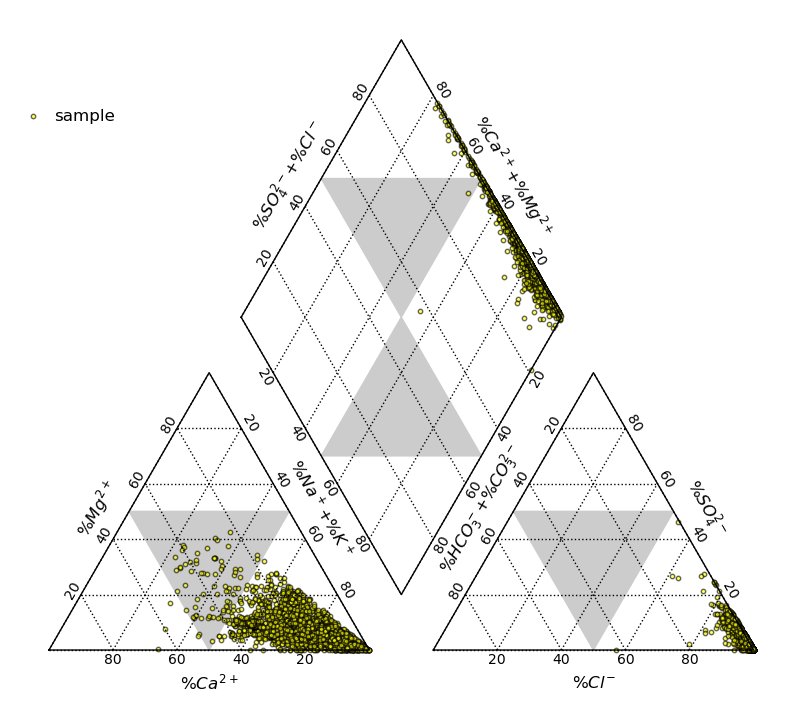

In [19]:
print('Patience please. This cell takes a while to run.')

image_name = 'TestPiper1-Normal'
triangle_piper.plot(df_data_wqchartpyformat,unit='mg/L',figname=image_name,figformat='png')

image_file_name = f'{image_name}.png'
move_image_file_to_images_folder(image_file_name)

Contour-filed Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 

File 'TestPiper2-Contour.png' moved to 'images' folder.


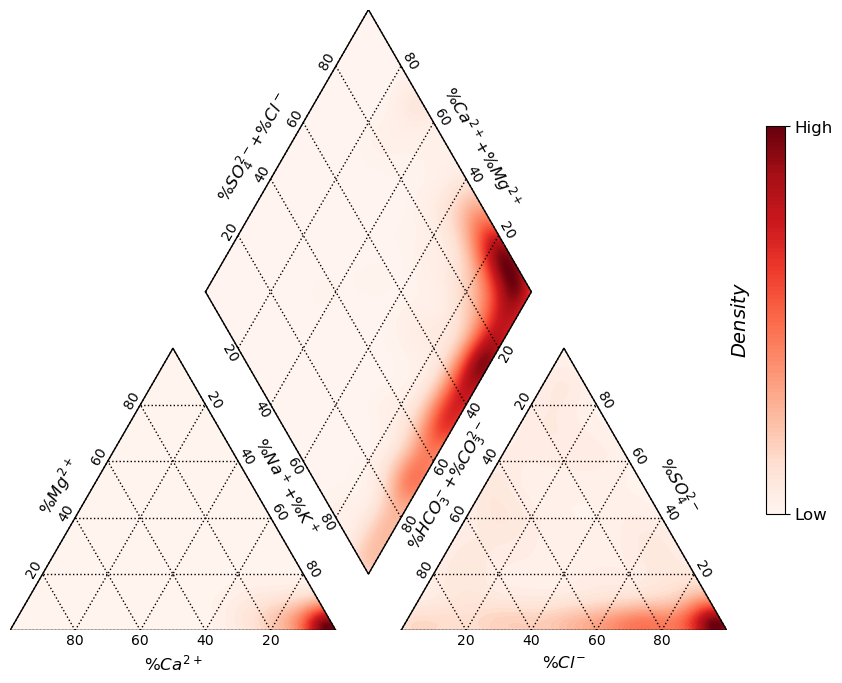

In [58]:
image_name = 'TestPiper2-Contour'
contour_piper.plot(df_data_wqchartpyformat, unit='mg/L', figname=image_name, figformat='png')

image_file_name = f'{image_name}.png'
move_image_file_to_images_folder(image_file_name)

Color-coded Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 

File 'TestPiper3-ColorCoded.png' moved to 'images' folder.


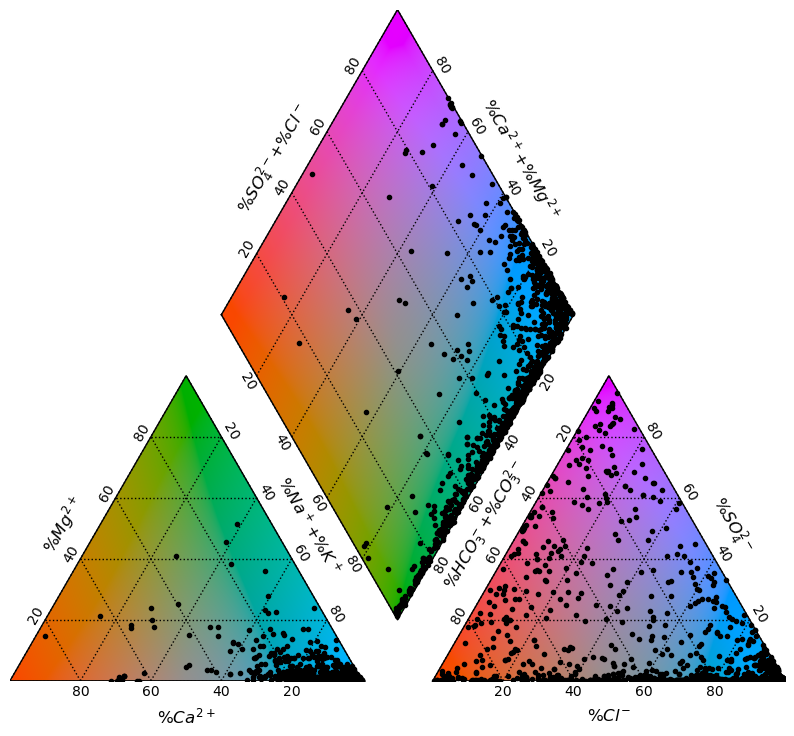

In [60]:
image_name = 'TestPiper3-ColorCoded'
color_piper.plot(df_data_wqchartpyformat, unit='mg/L', figname=image_name, figformat='png')

image_file_name = f'{image_name}.png'
move_image_file_to_images_folder(image_file_name)

### Geo Map of All Samples from Cleaned Data Set

### Geo Map(s) of Sample Subsets (if needed)